# Analysis of Cell-free and HIV - Figure 4

This notebook will present analyses and discussions of the GH-VAP project looking for potential microbiome causes/associations with individuals who produce broadly neutralizing antibodies to HIV; as well as everything else I can learn from the transcriptome. 

This specific notebook will handle the code to generate figure 3.

## Author: 
 **Mark Kowarsky**
 
 - **Date Updated:** 2018-10-24


#### Code cleaned by:
- Mercedes Dalman
- **Date Updated:** 2025-09

## Imports and stylings

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import HTSeq
import glob
import itertools
from collections import defaultdict
import matplotlib.dates as mdates
import os

#from wordcloud import WordCloud
from matplotlib.colors import to_hex

from ete3 import NCBITaxa#, TreeStyle, NodeStyle, faces

from IPython.core.pylabtools import figsize

from scipy.interpolate import PchipInterpolator
from scipy.stats.mstats import spearmanr

from sklearn import decomposition, manifold

from adjustText import adjust_text

import pysam

#%load_ext rpy2.ipython

In [2]:
# Colours from Material Design - https://material.io/tools/color/
green = "#388e3c"
light_green = "#6abf69"
dark_green = "#00600f"

blue = "#1976d2"
light_blue = "#63a4ff"
dark_blue = "#004ba0"

red = "#d32f2f"
light_red = "#ff6659"
dark_red = "#9a0007"

yellow = "#fbc02d"
light_yellow = "#fff263"
dark_yellow = "#c49000"

grey = "#616161"
light_grey = "#8e8e8e"
dark_grey = "#373737"

orange = "#f57c00"
light_orange = "#ffad42"
dark_orange = "#bb4d00"

purple = "#7b1fa2"
dark_purple = "#4a0072"
light_purple = "#ae52d4"

## Breadth of broadly neutralizing antibodies

In [3]:
# Load breadth metadata
breadth_metadata = pd.read_excel("../tables/Gates_metadata.xlsx", index_col=[22, 23])
breadth_metadata.index = ["_".join(map(str,x)) for x in breadth_metadata.index]
breadth_metadata["Patient"] = [x.split("_")[0] for x in breadth_metadata.index]
breadth_metadata["sample"] = "SAMPLE_" + breadth_metadata["Patient"] + "_" + breadth_metadata["Years PI"].astype(str)
breadth_metadata.set_index("sample", inplace=True)

In [4]:
design = pd.read_table("../tables/edgeR_design.txt", index_col=0)

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [5]:
meta1 = pd.read_excel("../tables/Gates_metadata.xlsx", sheet_name=1)
meta1["sample"] = "SAMPLE_" + meta1["PID"].astype(str) + 14*["_1", "_2", "_3"]
meta1.set_index("sample", inplace=True)

## Basic statistics

In [6]:
rsa = pd.read_table("../tables/samples/rSA.csv", index_col=0)
sa = pd.read_table("../tables/samples/SA.csv", index_col=0)

In [7]:
pre = pd.read_table("../tables/preprocess_stats.txt", index_col=0)

pre["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in pre.index]
pre = pre.groupby("group").sum()

# Non-human counts
nh = pd.read_table("../tables/not_human_stats.txt", names=["sample", "type", "end", "stat"])
nh["type"] = nh["type"] + "_" + nh["end"]
nh = nh.pivot(index="sample", columns="type", values="stat")

nh["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in nh.index]
nh = nh.groupby("group").sum()

In [8]:
# Order of samples
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [9]:
pre_rsa = pd.DataFrame(index=rsa.index, columns=["raw", "cleaned", "nonhuman"])
pre_rsa.loc[rsa.index, "raw"] = pre.loc[rsa.index, "raw_fastq.1"]
pre_rsa.loc[rsa.index, "cleaned"] = 100-\
                                    100*(pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["raw_fastq.1", "raw_fastq.U"]].sum(axis=1)
pre_rsa.loc[rsa.index, "cleaned_counts"] = (pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))
pre_rsa.loc[rsa.index, "nonhuman"] = 100*(nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["cleaned_fastq.1", "cleaned_fastq.U"]].sum(axis=1)
pre_rsa["human"] = 100 - pre_rsa["nonhuman"]
pre_rsa["human_counts"] = pre_rsa["cleaned_counts"] - nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1)

pre_rsa = pre_rsa.sort_index()
pre_rsa["Subject"] = [i.split("_")[1] for i in pre_rsa.index]
pre_rsa["Subject"] = [i[:-1] if "water" in i else i for i in pre_rsa["Subject"]]

pre_rsa = pre_rsa.loc[c + list(rsa.index.difference(c))] # Preserve order from before

In [10]:
meta1["other_name"] = meta1["PID"].astype(str) + "_" + meta1["visit code"].astype(str)
meta1["old_name"] = meta1.index
m = meta1.set_index("other_name")

## Transcriptome

In [11]:
genes = pd.read_table("../tables/gene_counts.txt", index_col=0).T

genes_duprm = genes.copy().loc[[s for s in genes.index if "duprm" in s]]
genes_duprm["sample"] = [s.split(".")[0] for s in genes_duprm.index]
genes_duprm = genes_duprm.groupby("sample").sum().T

genes = genes.copy().loc[[s for s in genes.index if "duprm" not in s]]
genes["sample"] = [s.split(".")[0] for s in genes.index]
genes = genes.groupby("sample").sum().T

In [12]:
just_genes = genes.iloc[:-5]
just_genes = genes.loc[[g for g in genes.index if "ENSG" in g]]
cpm = (1e6*just_genes.div(just_genes.sum()))
logCPM = np.log10(cpm+1)

X = logCPM.loc[:, meta1.index.difference(["SAMPLE_100200_1"])].T

In [14]:
#just_genes.loc[:, X.index].to_csv("just_gene_counts.txt", sep="\t") # Just good samples here

# Differential expression

In [13]:
# Load gene names and HIV associated genes
ensembl = pd.read_table("../tables/ensembl.tsv", index_col=0)
ensembl_clean = ensembl[ensembl["Gene name"].apply(lambda s: len(s.split("-"))) == 1]

hiv_genes = pd.read_excel("../tables/MalaCards-HIV.xlsx", index_col=0)
hiv_genes["gene"] = hiv_genes["Symbol"].apply(lambda s: s.split()[0])
hiv_genes.index = hiv_genes["gene"]
hiv_ensembl = [g for g in ensembl.index if ensembl.loc[g, "Gene name"] in hiv_genes["gene"].values]

In [14]:
# Build HIV Ensembl ID set from MalaCards sheet via gene symbols
hiv_symbols = (
    hiv_genes["Symbol"]
    .astype(str)
    .str.split().str[0]       # take first token like you did
    .str.upper()
    .unique()
)

# Normalize ensembl gene symbols to match casing and tokenization
ensembl["SYMBOL_UP"] = (
    ensembl["Gene name"].astype(str).str.split().str[0].str.upper())

hiv_ensembl_ids = set(
    ensembl.index[ensembl["SYMBOL_UP"].isin(hiv_symbols)])

In [15]:
# DE table
de_bNAbs = pd.read_table("../tables/bNAbs.de.new.txt", index_col=0)

# robust -log10(FDR)
de_bNAbs["-logP"] = -np.log10(de_bNAbs["FDR"].clip(lower=np.finfo(float).tiny))


In [16]:
# Add "Gene name"
de_bNAbs = de_bNAbs.join(ensembl[["Gene name"]], how="left").copy()

# Add HIV? 
de_bNAbs["HIV?"] = de_bNAbs.index.isin(hiv_ensembl_ids)
#de_bNAbs.to_csv("differential_expression_bNAbs.txt", sep="\t")

In [17]:
print("bNABs = Y", len(de_bNAbs.query("logFC > 1").query("FDR < 0.05")))
print("bNABs = N", len(de_bNAbs.query("logFC < -1").query("FDR < 0.05")))

bNABs = Y 256
bNABs = N 281


# EXTRA: Checking Pathways

In [18]:
genes_up = de_bNAbs.query("logFC > 1 and FDR <= 0.05")['Gene name'].to_list()
genes_down = de_bNAbs.query("logFC < -1 and FDR <= 0.05")['Gene name'].to_list()


In [19]:
import gseapy as gp
import re
# Run Enrichr on immune-relevant libraries
libraries = ["GO_Biological_Process_2023", "GO_Molecular_Function_2023", "Reactome_2022"]
enr = gp.enrichr(gene_list=genes_up, gene_sets=libraries, organism="Human", cutoff=1.0)

# Combine results from all libraries
df = pd.concat([enr.results.assign(Library=lib) 
                for lib, enr in enr.results.items()]) if isinstance(enr.results, dict) else enr.results

# Keep immune-related terms
pat = re.compile(r"immune|interferon|cytokine|lymphocyte|leukocyte|antigen|complement", re.I)
immune_terms = df[df["Term"].str.contains(pat, na=False)]

# Collect unique genes driving those terms
immune_genes = set()
for s in immune_terms["Genes"].dropna():
    immune_genes.update(g.strip() for g in s.split(";") if g.strip())  # gseapy uses ';' separated

pct = 100 * len(immune_genes) / len(genes_up) if genes_up else 0.0
print(f"Immune-related genes: {len(immune_genes)}/{len(genes_up)} ({pct:.1f}%)")
print("Example immune terms:\n", immune_terms[["Term","Adjusted P-value"]].head(10))

Immune-related genes: 99/256 (38.7%)
Example immune terms:
                                                  Term  Adjusted P-value
0                          Immune System R-HSA-168256      3.813606e-32
2                   Innate Immune System R-HSA-168249      1.926825e-24
3   Cytokine Signaling In Immune System R-HSA-1280215      2.215404e-16
8        Interferon Alpha/Beta Signaling R-HSA-909733      6.861368e-09
9                   Interferon Signaling R-HSA-913531      4.717647e-08
11               Adaptive Immune System R-HSA-1280218      3.367819e-06
12  Antigen processing-Cross Presentation R-HSA-12...      3.888829e-06
14            Interferon Gamma Signaling R-HSA-877300      7.342180e-06
16  Antigen Presentation: Folding, Assembly, Pepti...      3.853461e-05
21  SARS-CoV-2 Activates/Modulates Innate And Adap...      6.279416e-04


# Panel A

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


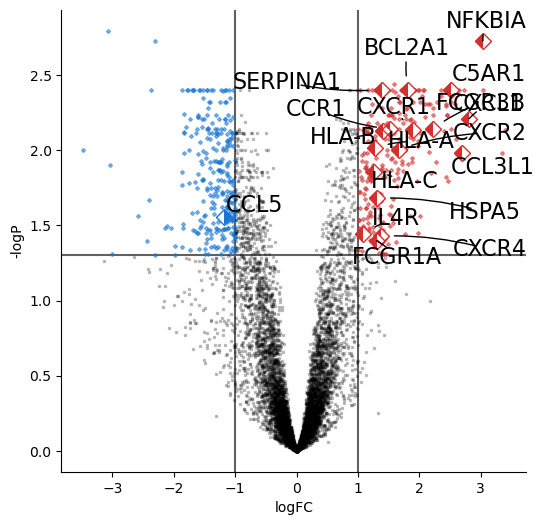

In [20]:
# Ensembl IDs in DE that are HIV-related
de_HIV = de_bNAbs[de_bNAbs['HIV?']].index

# Thresholded sets
ub = de_bNAbs.query("logFC > 1 and FDR <= 0.05").index
db = de_bNAbs.query("logFC < -1 and FDR <= 0.05").index

up_nonHIV   = ub.difference(de_HIV)
up_HIV      = ub.intersection(de_HIV)
down_nonHIV = db.difference(de_HIV)
down_HIV    = db.intersection(de_HIV)
rest        = de_bNAbs.index.difference(ub.union(db))


fig, ax = plt.subplots(figsize=(6,6))
# Up in bNAbs
de_bNAbs.loc[up_nonHIV].plot.scatter(x="logFC", y="-logP", color=red, alpha=0.5, s=4, marker="D", ax=ax)
i = de_bNAbs.loc[up_HIV]
ax.plot(i["logFC"], i["-logP"], color=red, marker="D",
        markerfacecoloralt="white", linewidth=0, markeredgewidth=0,
        fillstyle="left", markersize=8)
ax.plot(i["logFC"], i["-logP"], color=red, marker="D",
        markerfacecoloralt="white", linewidth=0, markeredgewidth=1,
        fillstyle="none", markersize=8)

# Down in bNAbs
de_bNAbs.loc[down_nonHIV].plot.scatter(x="logFC", y="-logP", color=blue, alpha=0.5, s=4, marker="D", ax=ax)
i = de_bNAbs.loc[down_HIV]
ax.plot(i["logFC"], i["-logP"], color=blue, marker="D",
        markerfacecoloralt="white", linewidth=0, markeredgewidth=0,
        fillstyle="right", markersize=8)
ax.plot(i["logFC"], i["-logP"], color=blue, marker="D",
        markerfacecoloralt="white", linewidth=0, markeredgewidth=1,
        fillstyle="none", markersize=8)

# Most points
de_bNAbs.loc[rest].plot.scatter(x="logFC", y="-logP", color='k', alpha=0.2, s=4, marker="s", ax=ax)

plt.axvline(x=-1, color=grey, zorder=0)
plt.axvline(x=1,  color=grey, zorder=0)
plt.axhline(y=-np.log10(0.05), color=grey, zorder=0)

label_ix = ub.union(db).intersection(de_HIV)

# Gene names for selected IDs
gene_names = ensembl.reindex(label_ix)["Gene name"]

fallback = pd.Series(label_ix, index=label_ix)
label_names = gene_names.combine_first(fallback)

texts = []
for g, name in label_names.items():
    texts.append(plt.text(
        x=de_bNAbs.at[g, "logFC"],
        y=de_bNAbs.at[g, "-logP"],
        s=name, zorder=101, fontsize=16
    ))

from adjustText import adjust_text

arrowkw = dict(
    arrowstyle='-',
    lw=1,
    shrinkA=10,  
    shrinkB=10,   
    connectionstyle="arc3,rad=0.08",  # gentle curve avoids strike-through
    mutation_scale=8,                 
)

adjust_text(
    texts,
    x=de_bNAbs.loc[label_ix, "logFC"],
    y=de_bNAbs.loc[label_ix, "-logP"],
    arrowprops=arrowkw,
    expand_text=(1.8, 2),
    expand_points=(1.2, 1.4),
)


sns.despine()
os.makedirs('../figures/figure4/panel_A/', exist_ok = True)
plt.savefig("../figures/figure4/panel_A/de_bnabs.svg")
plt.show()


# Panel B 

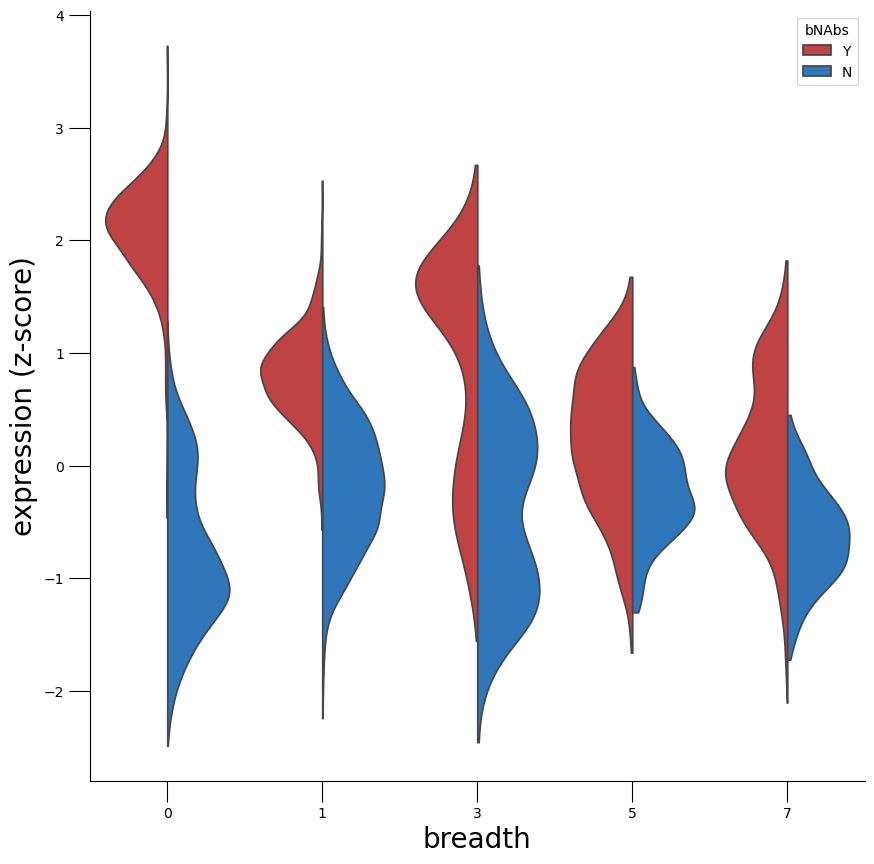

In [21]:
x = X.loc[:, ub].T
x = x.sub(x.mean(axis=1), axis=0)
x = x.div(x.std(axis=1), axis=0)

xm = pd.melt(x)
xm["bNAbs"] = design.loc[xm["sample"], "bNAbs"].values
xm["breadth"] = (breadth_metadata.loc[xm["sample"], "% breadth"].fillna(0).values * 18).astype(int)
cats = [0, 1, 3, 5, 7]
xm["breadth"] = pd.Categorical(xm["breadth"], categories=cats, ordered=True)

fig, ax = plt.subplots(1,1, figsize = (10,10))
pal = {"Y": red, "N": blue}

sns.violinplot(
    data=xm[xm["breadth"].isin(cats)],
    x="breadth", y="value",
    hue="bNAbs",
    hue_order=["Y","N"],  
    ax = ax,
    palette=pal,
    split=True,
    inner=None,
    order=cats,
    cut=0,                  
    density_norm="width"            # keep widths comparable
)

ax.set_ylabel("expression (z-score)", fontsize = 20)
ax.set_xlabel('breadth',fontsize = 20)
ax.tick_params('both', size = 15)
sns.despine()
os.makedirs('../figures/figure4/panel_B/', exist_ok = True)
plt.savefig("../figures/figure4/panel_B/de_bnabs.svg")
plt.show()


# Panel C - Correlation with production of bNAbs

In [22]:
breadth_corr = pd.read_csv("../tables/breadth_gene_correlation.txt", sep="\t", index_col=0)

In [23]:
antigen_presenting = ["B2M", "HLA-A", "HLA-F", "HLA-H", "HLA-G", "HLA-E", "HLA-B",
                      "HLA-C", "HFE", "BCAP31", "TAP2", "TAPBP", "TAP1", "PDIA3"]

other_antigen_presnting_MHC1 = ["B2M", "CALR", "CANX", "PDIA3", "HLA-A", "HLA-B", "HLA-C", 
                                "HLA-E", "HLA-F", "HLA-G", "HLA-H", "HSPA5", "SEC13", "TAP1", 
                                "TAP2", "TAPBP", "SEC24C", "SEC24D", "SEC24B", "SEC23A", "SEC24A",
                                "SEC31A", "SAR1B", "ERAP1", "ERAP2"]

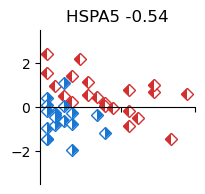

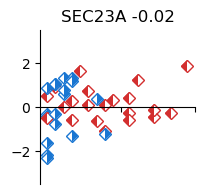

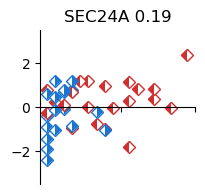

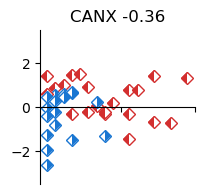

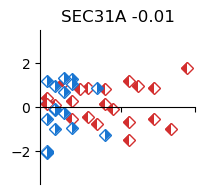

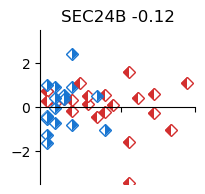

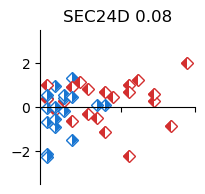

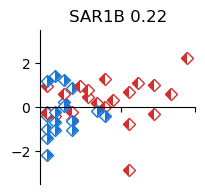

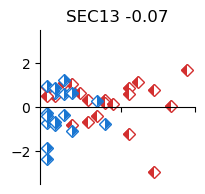

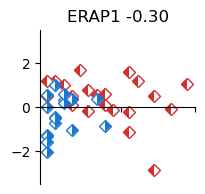

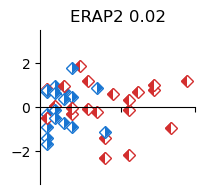

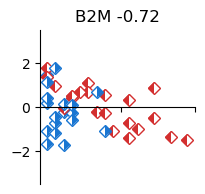

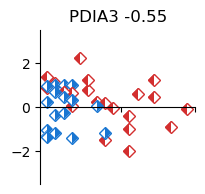

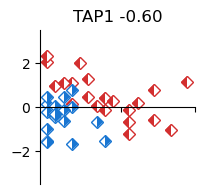

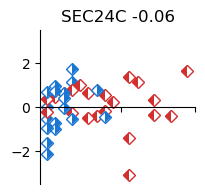

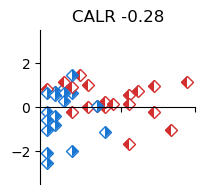

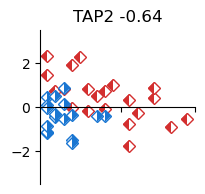

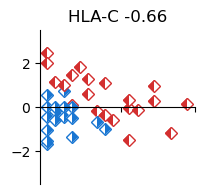

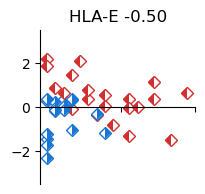

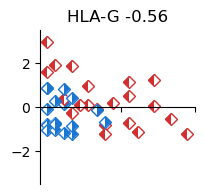

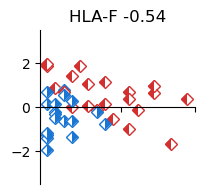

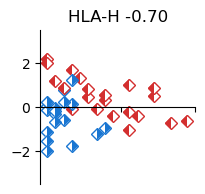

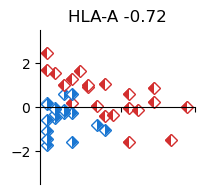

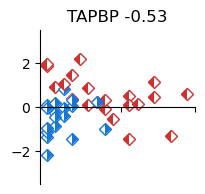

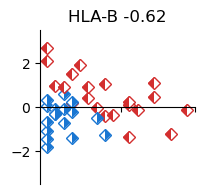

In [24]:
wanted = ensembl.index[ensembl["Gene name"].isin(other_antigen_presnting_MHC1)]
cols = X.columns.intersection(wanted)     
x = X.loc[:, cols].T
x = x.sub(x.mean(axis=1), axis=0)
x = x.div(x.std(axis=1), axis=0)
#x.index = ensembl.loc[x.index, "Gene name"]

for g in x.index:
    figsize(2, 2)
    for s in x.columns:
        if design.loc[s, "bNAbs"] == "Y":
            color=red
            fillstyle="left"
        else:
            color=blue
            fillstyle="right"
        plt.plot(100*breadth_metadata.loc[s, "% breadth"], x.loc[g, s], color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(100*breadth_metadata.loc[s, "% breadth"], x.loc[g, s], color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
    plt.title("{} {:.2f}".format(ensembl.loc[g, "Gene name"], breadth_corr.loc[g, "bNAbs"]))
    plt.ylim(-3.5, 3.5)
    plt.xticks([50, 100], ["", ""])
    ax = plt.gca()
    ax.spines['bottom'].set_position('center')
    sns.despine()
    os.makedirs('../figures/figure4/panel_C/', exist_ok = True)
    plt.savefig("../figures/figure4/panel_C/{}.svg".format(breadth_corr.loc[g, "Gene name"]))
    plt.show()